In [452]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import missingno as msno

Carga y reducción de registros de datasets

In [453]:
movies_df = pd.read_csv(r"E:\Repositorios y bases de datos\Henry DS\Proyecto-individual-N-1---LABS---Henry\datos_procesados\movies_df.csv")
director_actor_df = pd.read_csv(r"E:\Repositorios y bases de datos\Henry DS\Proyecto-individual-N-1---LABS---Henry\datos_procesados\director_actor_df.csv")

In [454]:
# Eliminación de columnas que pueden haber sido útiles para los endpoints pero que no usaría como parámentro para recoemndar
movies_df = movies_df.drop(columns=['original_title', 'release_date', 'return'])

movies_df

,budget,movie_id,revenue,title,vote_average,vote_count,genre
0,30000000.0,862,373554033.0,Toy Story,7.7,5415.0,Animation
1,65000000.0,8844,262797249.0,Jumanji,6.9,2413.0,Adventure
2,0.0,15602,0.0,Grumpier Old Men,6.5,92.0,Romance
3,16000000.0,31357,81452156.0,Waiting to Exhale,6.1,34.0,Comedy
4,0.0,11862,76578911.0,Father of the Bride Part II,5.7,173.0,Comedy
...,...,...,...,...,...,...,...
45461,0.0,439050,0.0,Subdue,4.0,1.0,Drama
45462,0.0,111109,0.0,Century of Birthing,9.0,3.0,Drama
45463,0.0,67758,0.0,Betrayal,3.8,6.0,Action
45464,0.0,227506,0.0,Satan Triumphant,0.0,0.0,Not available


## movies_df análisis

In [455]:
movies_df.dtypes

budget          float64
movie_id         object
revenue          object
title            object
vote_average     object
vote_count       object
genre            object
dtype: object

In [456]:
director_actor_df.dtypes

Unnamed: 0     int64
movie_id       int64
director      object
actor         object
dtype: object

In [457]:
# Primeras filas del dataset
print(movies_df.head())

# Información general del dataset
print(movies_df.info())

# Estadística descriptiva
print(movies_df.describe())


       budget movie_id      revenue                        title vote_average  \
0  30000000.0      862  373554033.0                    Toy Story          7.7   
1  65000000.0     8844  262797249.0                      Jumanji          6.9   
2         0.0    15602          0.0             Grumpier Old Men          6.5   
3  16000000.0    31357   81452156.0            Waiting to Exhale          6.1   
4         0.0    11862   76578911.0  Father of the Bride Part II          5.7   

  vote_count      genre  
0     5415.0  Animation  
1     2413.0  Adventure  
2       92.0    Romance  
3       34.0     Comedy  
4      173.0     Comedy  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        45466 non-null  float64
 1   movie_id      45466 non-null  object 
 2   revenue       45466 non-null  object 
 3   title         45466 non-null 

In [458]:
# Primeras filas del dataset
print(director_actor_df.head())

# Información general del dataset
print(director_actor_df.info())

# Estadística descriptiva
print(director_actor_df.describe())

   Unnamed: 0  movie_id         director  \
0           0       862    John Lasseter   
1           1      8844     Joe Johnston   
2           2     15602    Howard Deutch   
3           3     31357  Forest Whitaker   
4           4     11862    Charles Shyer   

                                               actor  
0  ['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...  
1  ['Robin Williams', 'Jonathan Hyde', 'Kirsten D...  
2  ['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...  
3  ['Whitney Houston', 'Angela Bassett', 'Loretta...  
4  ['Steve Martin', 'Diane Keaton', 'Martin Short...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42568 entries, 0 to 42567
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42568 non-null  int64 
 1   movie_id    42568 non-null  int64 
 2   director    42568 non-null  object
 3   actor       42568 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.3+ MB
None
  

Descripción

In [459]:
print(movies_df.describe())

             budget
count  4.546600e+04
mean   4.224300e+06
std    1.742359e+07
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    3.800000e+08


## Gráficos

Histograma

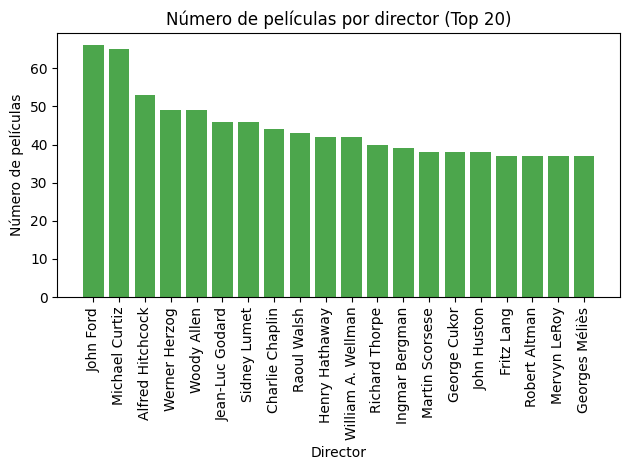

In [461]:
import matplotlib.pyplot as plt

# Recuento de la cantidad de películas por cada director
director_counts = director_actor_df['director'].value_counts()

# Límite a los primeros 20 directores más frecuentes para visualización
top_directors = director_counts.head(20)

# Creación del histograma
plt.bar(top_directors.index, top_directors.values, color='green', alpha=0.7)
plt.xlabel('Director')
plt.ylabel('Número de películas')
plt.title('Número de películas por director (Top 20)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


 <sub>A partir del director número 11, la cantidad de películas dirigidas comienza a disminuir más drásticamente. Por ejemplo, el director número 20 solo ha dirigido 50 películas, lo que es un 60% menos que la cantidad de películas dirigidas por John Ford, el director número 1.</sub>

Selección de columnas numéricas relevantes y cálculo de la matriz de correlación

In [462]:
# Elección de columnas para números
numeric_cols = ['budget', 'revenue', 'vote_average', 'vote_count']

# Conversión de valores no numericos a NaN
movies_df[numeric_cols] = movies_df[numeric_cols].replace('Not available', np.nan)

# Conversión a tipo numérico
movies_df[numeric_cols] = movies_df[numeric_cols].apply(pd.to_numeric)


# Cálculo de la matriz de correlación
correlation_matrix = movies_df[numeric_cols].corr()
print(correlation_matrix)

                budget   revenue  vote_average  vote_count
budget        1.000000  0.768776      0.073494    0.676642
revenue       0.768776  1.000000      0.083868    0.812022
vote_average  0.073494  0.083868      1.000000    0.123607
vote_count    0.676642  0.812022      0.123607    1.000000


Heatmap

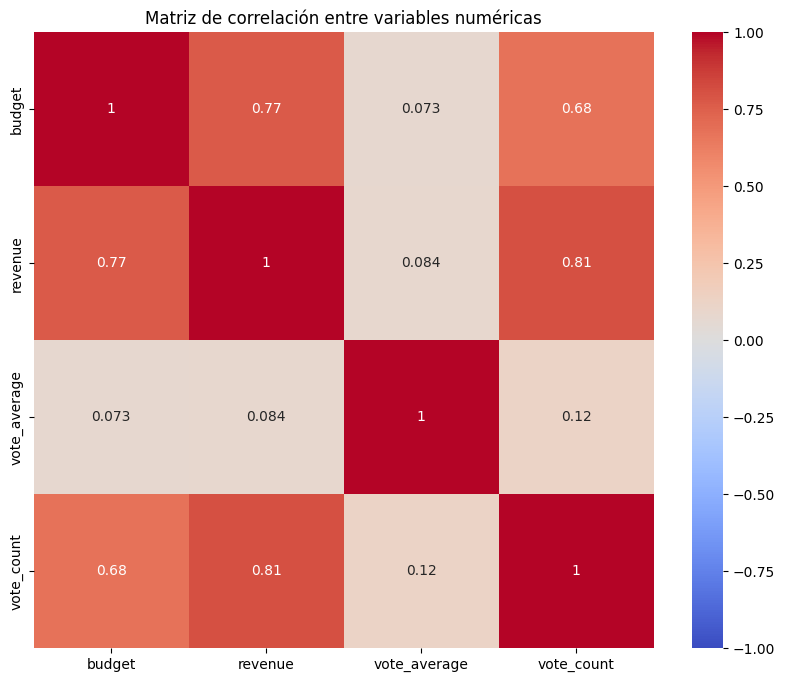

In [463]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

<sub>Las películas con mayores ingresos tienden a tener un mayor número de votos, según revenue y vote_count.



In [464]:
"""# Conversión de 'revenue' a numérico
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')

# Manejar NaNs
movies_df['revenue'].fillna(movies_df['revenue'].median(), inplace=True)

"""

"# Conversión de 'revenue' a numérico\nmovies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')\n\n# Manejar NaNs\nmovies_df['revenue'].fillna(movies_df['revenue'].median(), inplace=True)\n\n"

Gráfico de barras

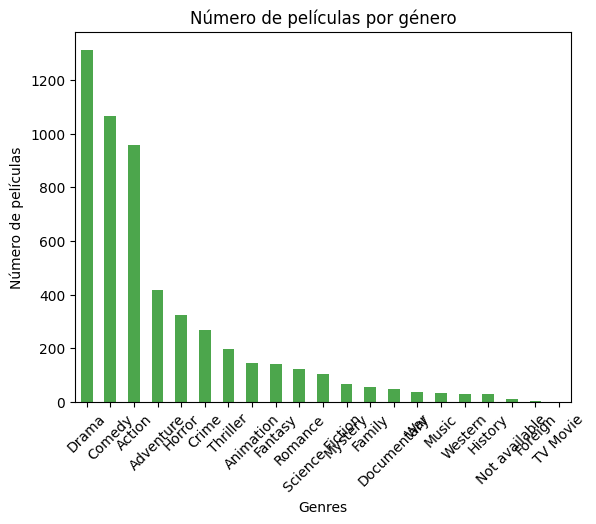

In [483]:
genre_counts = movies_df['genre'].value_counts()
genre_counts.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel('Genres')
plt.ylabel('Número de películas')
plt.title('Número de películas por género')
plt.xticks(rotation=45)
plt.show()

Diagrama de dispersión

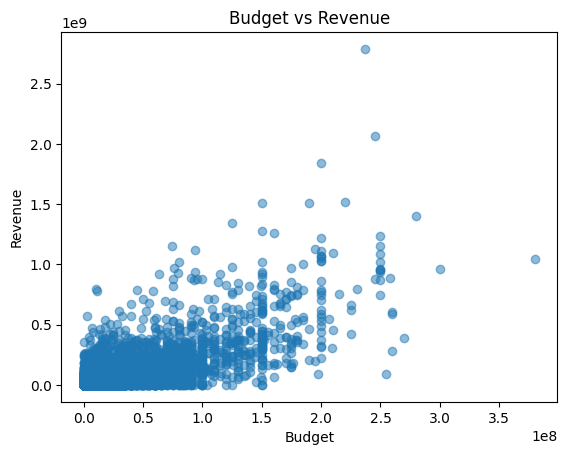

In [467]:
plt.scatter(movies_df['budget'], movies_df['revenue'], alpha=0.5)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Budget vs Revenue')
plt.show()

Nube de palabras según el título de la película

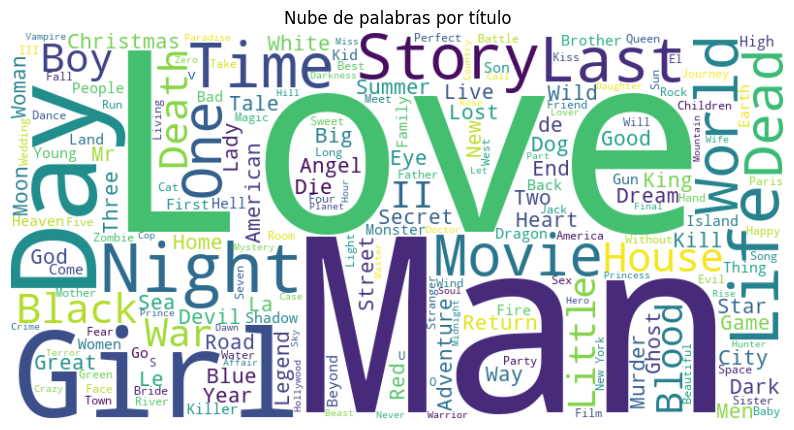

In [468]:
# Concatenación de todos los títulos en un solo string
text = ' '.join(movies_df['title'].astype(str))

# Creación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Muestra de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras por título')
plt.show()

Nube de palabras de género

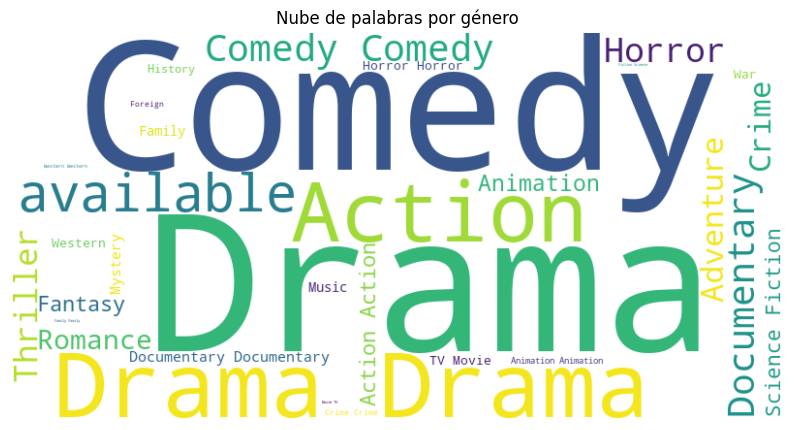

In [469]:
# Concatenación de todos los títulos en un solo string
text = ' '.join(movies_df['genre'].astype(str))

# Creación de la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Muestra de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras por género')
plt.show()

Identificación de outliers

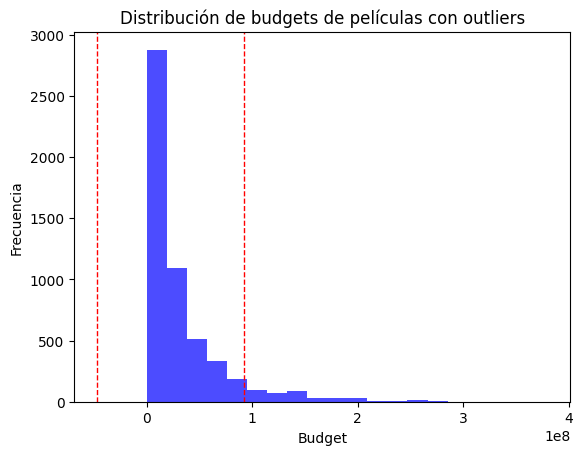

In [485]:
# Estadística para identificar outliers usando el método del rango intercuartílico (IQR)
Q1 = movies_df['budget'].quantile(0.25)
Q3 = movies_df['budget'].quantile(0.75)
IQR = Q3 - Q1

# Límites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Creación del histograma marcando los outliers
plt.hist(movies_df['budget'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Budget')
plt.ylabel('Frecuencia')
plt.title('Distribución de budgets de películas con outliers')
plt.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=1)
plt.axvline(x=upper_bound, color='red', linestyle='dashed', linewidth=1)
plt.show()


## director_actor_df análisis

Descripción

In [488]:
director_actor_df = director_actor_df.drop(columns=['Unnamed: 0'])

print(director_actor_df.head())
print(director_actor_df.info())
print(director_actor_df.describe())

   movie_id         director  \
0       862    John Lasseter   
1      8844     Joe Johnston   
2     15602    Howard Deutch   
3     31357  Forest Whitaker   
4     11862    Charles Shyer   

                                               actor  
0  ['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...  
1  ['Robin Williams', 'Jonathan Hyde', 'Kirsten D...  
2  ['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...  
3  ['Whitney Houston', 'Angela Bassett', 'Loretta...  
4  ['Steve Martin', 'Diane Keaton', 'Martin Short...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42568 entries, 0 to 42567
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  42568 non-null  int64 
 1   director  42568 non-null  object
 2   actor     42568 non-null  object
dtypes: int64(1), object(2)
memory usage: 997.8+ KB
None
            movie_id
count   42568.000000
mean   103587.573858
std    110421.188224
min         2.000000
25%     25032.750

## Gráficos

Datos faltantes

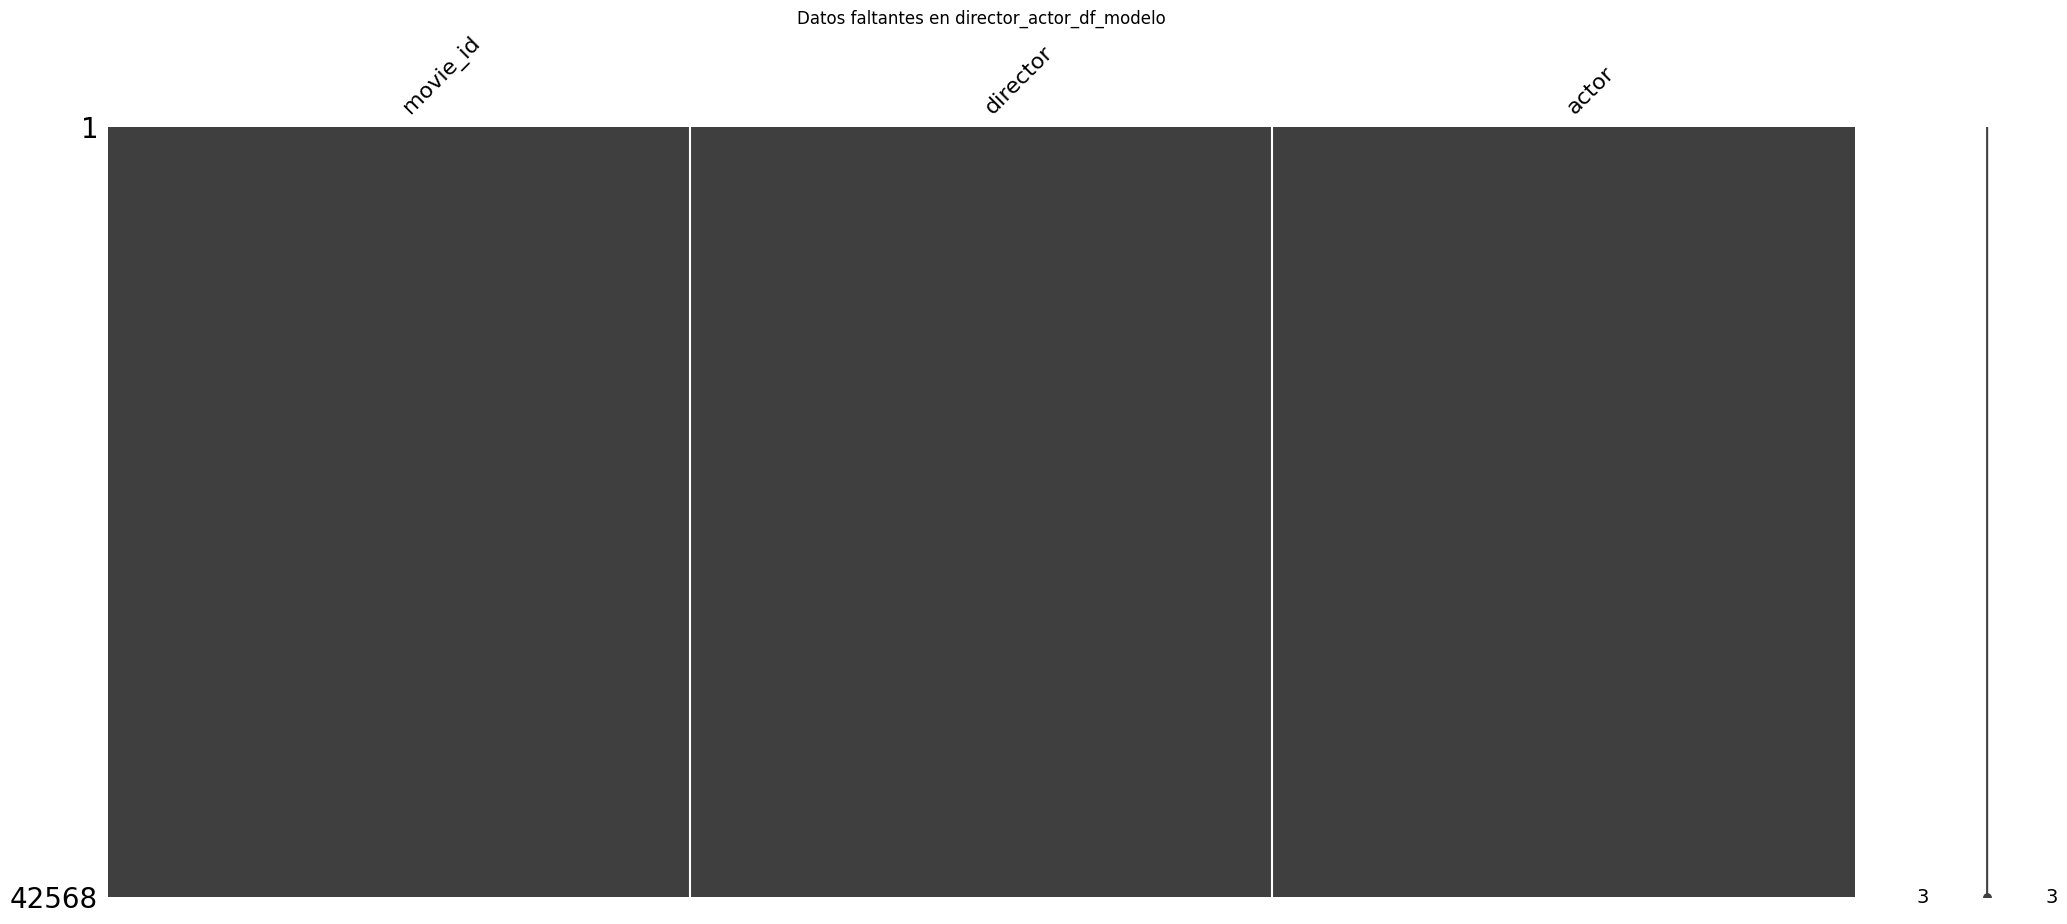

In [489]:
msno.matrix(director_actor_df)
plt.title('Datos faltantes en director_actor_df_modelo')
plt.show()

Nube de palabras según directores

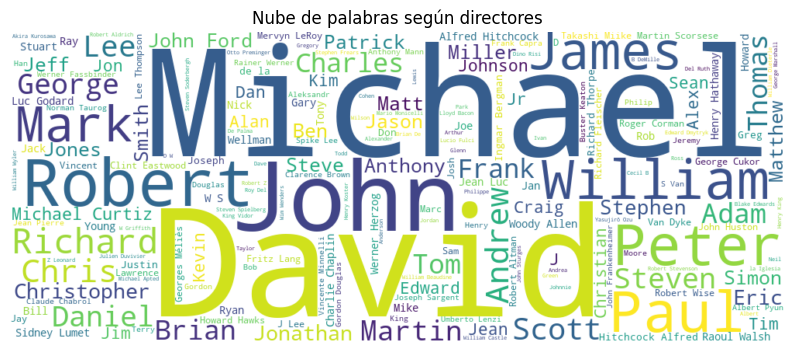

In [474]:
director_names = director_actor_df['director'].str.split(' ')

# Concatenación de nombres y apellidos de directores en un solo string
text_directors = ' '.join([' '.join(name) for name in director_names])

# Creación de la nube de palabras para directores
wordcloud_directors = WordCloud(width=1000, height=400, background_color='white').generate(text_directors)

# Muestra de la nube de palabras para directores
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_directors, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras según directores')
plt.show()

Nube de palabras según actores

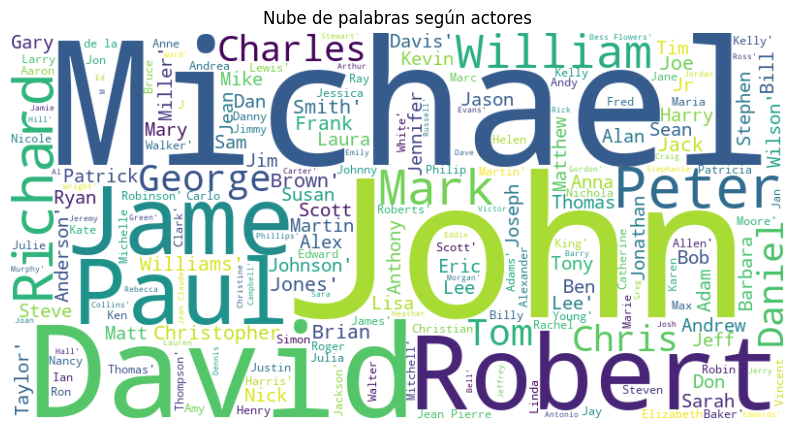

In [475]:
actor_names = director_actor_df['actor'].str.split(' ')

# Concatenación de nombres y apellidos de actores en un solo string
text_actors = ' '.join([' '.join(name) for name in actor_names])

# Creación de la nube de palabras para actores
wordcloud_actors = WordCloud(width=800, height=400, background_color='white').generate(text_actors)

# Muestra de la nube de palabras para actores
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_actors, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras según actores')
plt.show()